In [1]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import numpy as np

import time
from sklearn.metrics import accuracy_score, roc_auc_score
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sb
###

# Plot settings
%config InlineBackend.figure_format = 'svg'
sb.set()
from tqdm import tqdm

import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

import sys
sys.path.insert(0, '/directory/tothe/handshakefile/')

import stylised_facts_data_utilities.createLOB as createLOB

%matplotlib inline
import os

from scipy.stats import norm, ttest_ind

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [2]:
import logging


def logger(name, level=logging.INFO):
    tmp_logger = logging.getLogger(name)
    if not tmp_logger.handlers:
        formatter = logging.Formatter('%(asctime)s %(name)s  %(levelname)s %(message)s')
        handler = logging.StreamHandler()
        handler.setFormatter(formatter)

        tmp_logger.setLevel(level)
        tmp_logger.addHandler(handler)
    return tmp_logger

In [3]:
dataFolder = '/media/ak/WorkDrive/Data'
figures_destination = '/home/ak/Documents/Research/Papers/figures/'

In [4]:
quotes =[f for f in os.listdir(dataFolder) if str('_quotes') in f]
trades =[f for f in os.listdir(dataFolder) if str('_trades') in f]

In [5]:
symbols = ['VIX',  'FB1',  'TU1',  'G_1',  'RX1',  'OE1',  'TY1',  'FV1',
 'JB1',  'RX1',  'DU1',  'KE1',  'US1',  'YM1', 'XM1',  'VXX'] 

In [7]:
symbolIdx = 2
symbol = sorted(symbols)[symbolIdx]
print(symbol)
quotesFileCh = os.path.join(dataFolder, quotes[symbolIdx])
tradesFileCh = os.path.join(dataFolder, trades[symbolIdx])

quotesFileCh

FV1


'/media/ak/WorkDrive/Data/TU1_Comdty_quotes'

In [16]:
## get common Dates
quotesDates = sorted([f.split(".csv")[0] for f in os.listdir(quotesFileCh)])
tradesDates = sorted([f.split(".csv")[0] for f in os.listdir(tradesFileCh)])
intersectionDates = list(set(quotesDates).intersection(tradesDates))
quotesDates[0:10]

['20180416',
 '20180417',
 '20180418',
 '20180419',
 '20180420',
 '20180423',
 '20180424',
 '20180425',
 '20180426',
 '20180427']

In [17]:
def quantile_plot(x, **kwargs):
    quantiles , xr = stats.probplot(x, fit= True)
    plt.scatter(xr, quantiles, **kwargs)
def returns(s):
    arr = np.diff(np.log(s))
    return (pd.Series(arr, index=s.index[1:]))
import statsmodels.api as sm

def plot_autocorr(bar_types,bar_returns):
    f,axes=plt.subplots(len(bar_types),figsize=(20,14))

    for i, (bar, typ) in enumerate(zip(bar_returns, bar_types)):
        sm.graphics.tsa.plot_acf(bar, lags=120, ax=axes[i],
                                 alpha=0.05, unbiased=True, fft=True,
                                 zero=False,
                                 title=f'{typ} AutoCorr')
        
    file_name = 'multiclocks_autocorrel.png'
    plt.savefig(os.path.join(figures_destination,file_name))
    plt.legend()
    plt.tight_layout() 

In [18]:
class volatilityEstimation(object):
    
    def __init__(self, df, tick_window=20, clean=True):
        self.df = df
        self.tick_window = tick_window
        self.mu_1 =  np.sqrt((2 / np.pi))
        self.mu_43 = 2**(2 / 3) * scipy.special.gamma(7 / 6) ** scipy.special.gamma(1 / 2) ** (-1)
        self.clean = True #set to true to remove nans at the beginning of the period
        self.trading_seconds_btc = 86400
        self.trading_seconds_futures = 23400
                      
        self.column_open ='micro_price_open'
        self.column_high = 'micro_price_high'
        self.column_low = 'micro_price_low'
        self.column_close = 'micro_price_close'

        self.log_hl = (df[str(self.column_high)] / df[str(self.column_low)]).apply(np.log)
        self.log_co = (df[str(self.column_close)] / df[str(self.column_open)]).apply(np.log)
        # median sampling frequency
        
        self.z = pd.DataFrame([((x.hour * 60 + x.minute) * 60 + x.second) for x in self.df['TimeStamp_open']]).diff().fillna(0).astype('float64')
        self.clean_arrival_rates = np.asarray(self.z[(self.z>self.z.quantile(0.003)) & ( self.z < self.z.quantile(0.97) ) ].dropna()).astype('float64')
        # clean arrival rates after i remove all the outliers
        self.mean_sampling_frequency = np.mean(np.asarray(self.clean_arrival_rates))
        
 
    def arrival_rates(self):
        
        z = pd.DataFrame([((x.hour * 60 + x.minute) * 60 + x.second) for x in self.df['TimeStamp_open']]).diff().fillna(0).astype('float64')
        clean_arrival_rates = np.asarray(z[(z>z.quantile(0.003)) & (z<z.quantile(0.97)) ].dropna()).astype('float64')
                                         # clean arrival rates after i remove all the outliers
        
        return clean_arrival_rates
        
    
    def M_parameter(self):
        """
        normalised sampling frequency for adjustments
        """
       
        M_btc = self.trading_seconds_btc / self.mean_sampling_frequency
        M_futures = self.trading_seconds_futures / self.mean_sampling_frequency        
        
        return [M_btc, M_futures]
        
    
    def garmanKlass(self, trading_periods):
        
        rs = 0.5 * self.log_hl ** 2 - (2 * np.log(2) - 1) * self.log_co ** 2

        def f(v):
            return (trading_periods * v.mean()) ** 0.5

        result = rs.rolling(window=self.tick_window, center=False).apply(func=f)

        if  self.clean:
            return result.dropna()
        else:
            return result
    
    def parkinson(self, trading_periods, clean = True):

        rs = (1.0 / (4.0 * np.log(2.0))) *(self.df[str(self.column_high)] / self.df[str(self.column_close)]).apply(np.log) ** 2.0

        def f(v):
            return trading_periods * v.mean() ** 0.5

        result = rs.rolling(window=self.tick_window, center=False).apply(func=f)

        if self.clean:
            return result.dropna()
        else:
            return result
    
    def bipower_variation(self, rollingWindow=5):
        '''
        Bipower Variation (BV) is the sum of the product of absolute time series returns
        :param column: price column
        :return: returns bivariate variation
        Barnhorf - Nielse & Shephard 2004 & 2006
        '''
        bv = self.mu_1 ** (-2) * ((self.log_hl.abs() *self.log_hl.shift(1).abs()).fillna(0).rolling(rollingWindow).sum())
        
        if self.clean:
            return bv.dropna()
        else:
            return bv

    
    def tripower_quarticity(self, rollingWindow=5, sampling_param = 0):
        """
        using M for BTC here - change sampling param to 1 for everything else
        """
        tpq = self.M_parameter()[sampling_param] * self.mu_43 ** (-3) * (( self.log_hl.abs()**(4 /3) * self.log_hl.shift(1).abs() **(4 / 3) * self.log_hl.shift(2).abs() **(4 / 3) ).rolling(rollingWindow).sum().fillna(0))
        
        if self.clean:
            
            return tpq.dropna()
        else:
            return tpq

    
    def realised_variance(self, rollingWindow=5):
        """
        realised variance - andersen & bollerselv -1998
        """

        realvar = (self.log_hl **2).rolling(rollingWindow).sum().fillna(0)
        
        if self.clean:
            return realvar.dropna()
        else:
            return realvar
    
    def realised_absolute_variation(self, rollingWindow=5, sampling_param = 0):
        """
        realised absolute variation - Forsberg & Ghysels 2007
        using M for BTC here - change sampling param to 1 for everything else
        """
        
        realabsovar = self.mu_1 **(-2) *self.M_parameter[sampling_param] **(-0.5) * self.log_hl.rolling(rollingWindow).sum().fillna(0)
        
        return realabsovar
    
    def realised_skewness_kurtosis(self, rollingWindow = 15, sampling_param = 0):
        
        """
        set the rolling window to 10-15
        sampling param for BTC ~ 0
        """
        
        rm3 = (self.log_hl **3).rolling(rollingWindow).sum().fillna(0)
        rm4 = (self.log_hl **4).rolling(rollingWindow).sum().fillna(0)
        
        rs = np.sqrt(self.M_parameter()[sampling_param]) * (rm3 / self.realised_variance(rollingWindow = rollingWindow)) **(3/2)
        rk = self.M_parameter()[sampling_param] * (rm4 / self.realised_variance(rollingWindow = rollingWindow)) ** 2
        
        return rs, rk
    
    def jumps_test(self, rollingWindow, sampling_param = 0):
        """
        Jump test by Huang and Tauchen 2005
        adopted by repo: RealisedQuantities
        """
        
        j1 = (np.log(self.realised_variance(rollingWindow= rollingWindow)) - np.log(self.bipower_variation(rollingWindow = rollingWindow))) 
        j2 = (((self.mu_1 **-4) +2* (self.mu_1 **-2) -5 ) / 
              (self.M_parameter()[0]*self.tripower_quarticity(rollingWindow = rollingWindow, sampling_param=sampling_param)
                *(self.bipower_variation(rollingWindow = rollingWindow)**-2)))
        
        j = j1 / (j2 ** 0.5)          
        
        
        return (j.abs() >= stats.norm.ppf(0.995))*1 # can also look at 0.999)*
    
    def relative_jump_measure(self, rollingWindow, sampling_param = 0):

        nominator = (self.realised_variance(rollingWindow= rollingWindow) 
                     - self.bipower_variation(rollingWindow = rollingWindow))
        
        measure_to_return = nominator / self.bipower_variation(rollingWindow = rollingWindow)
        
        return measure_to_return

        
    

    def negative_semivariance(self, x):
        """
        input: returns
        negative realised semivariance
        Barndorff- Nielsen
        """
        return x.apply(lambda x: (x**2))*(x<0).sum()

    def positive_semivariance(self, x):
        """
        input: returns
        positive realised semivariance
        Barndorff- Nielsen
        """
        return x.apply(lambda x: (x**2))*(x>0).sum()
    
    def signed_jump_variation(self, x):
        
        sjv = self.positive_semivariance(x) -self.negative_semivariance(x)
        sjv_p = sjv*(sjv>0)
        sjv_n = sjv*(sjv<0)
        
        return sjv_p, sjv_n
    
    def continuous_discontinuous_quadratic_variance(self):
        
        """
        seperate continuous and discontinuous parts of quadratic variation
        
        """
        pass                                                                                                                                 




class descriptiveStats(object):
       
        def __init__(self, df):
        
            self.df = df
            self.column_open ='micro_price_open'
            self.column_high = 'micro_price_high'
            self.column_low = 'micro_price_low'
            self.column_close = 'micro_price_close'
            self.log_hl = (df[str(self.column_high)] / df[str(self.column_low)]).apply(np.log)
            self.log_co = (df[str(self.column_close)] / df[str(self.column_open)]).apply(np.log)
        
        def base_descriptive_stats(self):

            desc_stats =dict()
            desc_stats['median_hl'] = np.median(self.log_hl)
            desc_stats['mean_co'] = np.median(self.log_co)
            desc_stats['quantile_95_hl'] = self.log_hl.quantile(0.95)
            desc_stats['quantile_95_co'] = self.log_co.quantile(0.95)
            desc_stats['q3_75_hl'] = self.log_hl.quantile(0.75)
            desc_stats['q3_75_co'] = self.log_co.quantile(0.75)
            desc_stats['q1_25_hl'] = self.log_hl.quantile(0.25)
            desc_stats['q1_25_co'] = self.log_co.quantile(0.25)
            desc_stats['outlier_lower_limit_hl'] = desc_stats['q1_25_hl'] - 1.5*(desc_stats['q3_75_hl'] - desc_stats['q1_25_hl'])
            desc_stats['outlier_upper_limit_hl'] = desc_stats['q3_75_hl'] + 1.5*(desc_stats['q3_75_hl'] - desc_stats['q1_25_hl'])
            desc_stats['lower_limit_outliers'] = self.log_hl[self.log_hl > desc_stats['outlier_lower_limit_hl']].count()
            desc_stats['upper_limit_outliers'] = self.log_hl[self.log_hl > desc_stats['outlier_upper_limit_hl']].count()
            desc_stats['total_outliers'] = desc_stats['lower_limit_outliers'] + desc_stats['upper_limit_outliers']
            
            return desc_stats

        
        


In [19]:

class DataLoader:
    """
    loads data and constructs full LOB and calendar bars for each one
    """
    def __init__(self, data_location, 
                 symbol,
                 dates, 
                 use_columns, 
                 calendar_resample,
                 trade_volume_width, 
                 ticks_width, 
                 usd_volume_width):
        
        self._data_location = data_location
        self._symbol= symbol
        self._input_dates = dates
        self._use_columns = use_columns
        self._calendar_resample = calendar_resample
        self._ticks_width = ticks_width
        self._trade_volume_width = trade_volume_width
        self._usd_volume_width = usd_volume_width
        self._dates = []
        self._bars_dict = {}
        self.calendar_bars = []
        self.volume_bars = []
        self.tick_bars = []
        self.usd_volume_bars = []
        self._logger = logger('DataLoader')
#         self._symbols = sorted(['VIX',  'FB1',  'TU1',  'G_1',  'RX1',  'OE1',  'TY1',  'FV1',  'JB1',  'RX1',  'DU1',  'KE1',  'US1',  'YM1', 'XM1',  'VXX'] )
        self._data_folder = data_location
        
        self._quotes_string = "".join((self._symbol, '_Comdty_quotes' ))
        self._trades_string = "".join((self._symbol, '_Comdty_trades' ))
        
#         self._quotes_files =sorted([ f for f in os.listdir(self._data_folder) if str('_quotes') in f])
#         self._trades_files = sorted([f for f in os.listdir(self._data_folder) if str('_trades') in f])
        
        self._quotes_Files = os.path.join(self._data_folder, self._quotes_string)
        self._trades_Files = os.path.join(self._data_folder, self._trades_string)
    
    def load_and_format_data(self):
        mergedFile = dict()
        for date in self._input_dates:
            dateToLoad = os.path.join(date + '.csv')
            self._logger.info(f"Loading data for:{date}")
            
            quotesDateFile = os.path.join(self._quotes_Files, dateToLoad)
            print(quotesDateFile)
            tradesDateFile = os.path.join(self._trades_Files, dateToLoad)
            print(tradesDateFile)
            
            try:
                qt_tmp_df = pd.read_csv(quotesDateFile, usecols=self._use_columns)
                qt_tmp_df['TradeTime'] = pd.to_datetime(qt_tmp_df.time).values
                              
                quotes_df =pd.merge_asof(qt_tmp_df[qt_tmp_df['type'] =='BID'].dropna().fillna("ffill").sort_values('TradeTime')
                                         , qt_tmp_df[qt_tmp_df['type'] =='ASK'].dropna().fillna("ffill").sort_values('TradeTime'), 
                                         on='TradeTime', allow_exact_matches=True)
                
                quotes_df = quotes_df.rename( columns={'value_x': 'BestBid', 'value_y': 'BestAsk',
                 'size_x': 'BidSize', 'size_y': 'AskSize', 'time_x': 'QuoteTime' })
                              
                tr_tmp_df = pd.read_csv(tradesDateFile, usecols=self._use_columns)
                tr_tmp_df['TradeTime'] = pd.to_datetime(tr_tmp_df.time).values
                trades_df= tr_tmp_df.dropna().fillna("ffill").sort_values('TradeTime')
                trades_df = trades_df.rename( columns={'value': 'TradePrice', 
                                                       'size': 'TradeSize'})
                trades_columns = ['TradeSize', 'type','TradePrice','TradeTime']
                
                LOB =pd.merge_asof(quotes_df, trades_df[trades_columns].sort_values('TradeTime'), on='TradeTime', allow_exact_matches=True)
                
                LOB.BidSize = LOB['BidSize'].replace(0, 1)
                LOB.AskSize = LOB['AskSize'].replace(0, 1)
                LOB['TimeStamp'] = pd.to_datetime(LOB.TradeTime).dt.time
                LOB['TradeVolume'] = LOB['TradeSize'].fillna(0)
                LOB['total_traded_volume'] = LOB.TradeVolume
                LOB['milliSeconds'] = [(((x.hour * 60 + x.minute) * 60 + x.second) * 1000) for x in LOB['TimeStamp']]
                LOB['dollar_traded_volume'] = pd.Series(LOB.TradePrice * LOB.TradeVolume).fillna(0)
                LOB['timeStampIdx'] = pd.DatetimeIndex(LOB.time_y)
                LOB['micro_price'] = (LOB.BestAsk * LOB.AskSize + LOB.BestBid * LOB.BidSize) / (LOB.AskSize + LOB.BidSize)  #
                
                mergedFile[date] = LOB
                
            except FileNotFoundError:
                self._logger.info(f"Data for day {date} does not exist. Skipping this day")
        return mergedFile
    
    def apply_micro_structure_features(self, df):
        
        self._logger.info("Applying micro-structure features")
        
     
        df['weighted_average_bid_price'] = pd.DataFrame(df.filter(like='bid_price', axis=1).values).mul(
        pd.DataFrame(df.filter(like='bid_size', axis=1).values)).sum(axis=1) / pd.DataFrame(df.filter(like='bid_size', axis=1).values).sum(axis=1)
        
        df['weighted_average_ask_price'] = pd.DataFrame(df.filter(like='ask_price', axis=1).values).mul(
            pd.DataFrame(df.filter(like='ask_size', axis=1).values)).sum(
            axis=1) / pd.DataFrame(df.filter(like='ask_size', axis=1).values).sum(axis=1)
        df['weighted_activity_spread'] = df['weighted_average_ask_price'] - df['weighted_average_bid_price']
        df['total_size'] = (pd.DataFrame(df.filter(like='ask_size', axis=1).values).sum(axis=1) +
                            pd.DataFrame(df.filter(like='bid_size', axis=1).values).sum(axis=1))
        df['micro_price'] = ((pd.DataFrame(df.filter(like='bid_price', axis=1).values).mul(
            pd.DataFrame(df.filter(like='bid_size', axis=1).values)).sum(axis=1) +
                              pd.DataFrame(df.filter(like='ask_price', axis=1).values).mul(
                                  pd.DataFrame(df.filter(like='ask_size', axis=1).values)).sum(axis=1))) / df['total_size']
        df['price_imbalance'] = ((pd.DataFrame(df.filter(like='ask_price', axis=1).values).mul(
            pd.DataFrame(df.filter(like='ask_size', axis=1).values)).sum(axis=1) -
                                  pd.DataFrame(df.filter(like='bid_price', axis=1).values).mul(
                                      pd.DataFrame(df.filter(like='bid_size', axis=1).values)).sum(axis=1))) / df[
                                    'total_size']
        df['pct_change_micro_price'] = df.micro_price_close.pct_change()
        df['simple_mid_price'] = 0.5 * (pd.DataFrame(df.filter(like='ask_price', axis=1)).mean(axis=1) +
                                        pd.DataFrame(df.filter(like='bid_price', axis=1)).mean(axis=1))

        # TODO: do we want to be using pct_change here or log returns?
        return df

    @staticmethod
    def prep_bars(df, drop_col):
        df.columns = [f"{i[0]}_{j}" for i, j in zip(df.columns, ['open', 'high', 'low', 'close'] * len(df.columns))]
        if drop_col:
            df.drop([f"{drop_col}_{i}" for i in ['open', 'high', 'low', 'close']], axis=1, inplace=True)
        return df

    
    def drop_lob_columns(df):
        #not using this anywhere at the moment
        
        ask_price_columns_to_be_dropped = list(pd.DataFrame(df.filter(like='ask_price_', axis=1)).columns.values)
        ask_size_columns_to_be_dropped = list(pd.DataFrame(df.filter(like='ask_size_', axis=1)).columns.values)
        bid_size_columns_to_be_dropped = list(pd.DataFrame(df.filter(like='bid_size_', axis=1)).columns.values)
        bid_price_columns_to_be_dropped = list(pd.DataFrame(df.filter(like='bid_price_', axis=1)).columns.values)
        time_stamps = ['timestamp', 'timestamp.1', 'exchange_time', 'feed_time']
        columns_to_be_dropped = ask_price_columns_to_be_dropped + ask_size_columns_to_be_dropped + \
                                bid_size_columns_to_be_dropped + bid_price_columns_to_be_dropped + \
                                time_stamps
        df = df.drop(columns=columns_to_be_dropped)

        return df
    
    def get_bars(self, df):
        
        self._logger.info('Calculating calendar clock')
        calendar_bars = df.resample(rule=self._calendar_resample, on='timeStampIdx').agg(['first', 'max', 'min', 'last'])
        calendar_bars = self.prep_bars(calendar_bars, 'timeStampIdx')

        self._logger.info('Calculating volume clock')
        # TODO: Doing this on day-by-day basis. We lose the last turn of the clock each day
        df['cum_total_trade_volume'] = df.total_traded_volume.cumsum()
        df['volume_bucket'] = np.floor(df.cum_total_trade_volume / self._trade_volume_width)
        volume_bars = df.groupby(by='volume_bucket').agg(['first', 'max', 'min', 'last']).iloc[1:-1]
        volume_bars = self.prep_bars(volume_bars, 'cum_total_trade_volume')
        df.drop(['cum_total_trade_volume', 'volume_bucket'], axis=1, inplace=True)

        self._logger.info('Calculating tick clock')
        # TODO: ticks here means any change to the order book. Not necessarily a trade. Can add that clock too
        df['tick_count'] = range(len(df))
        df['tick_bucket'] = np.floor(df.tick_count / self._ticks_width)
        tick_bars = df.groupby(by='tick_bucket').agg(['first', 'max', 'min', 'last']).iloc[1:-1]
        tick_bars = self.prep_bars(tick_bars, 'tick_count')
        df.drop(['tick_count', 'tick_bucket'], axis=1, inplace=True)

        self._logger.info('Calculating usd volume clock')
        df['cum_usd_volume'] = df.dollar_traded_volume.cumsum()
        df['usd_volume_bucket'] = np.floor(df.cum_usd_volume / self._usd_volume_width)
        usd_volume_bars = df.groupby(by='usd_volume_bucket').agg(['first', 'max', 'min', 'last']).iloc[1:-1]
        usd_volume_bars = self.prep_bars(usd_volume_bars, 'cum_usd_volume')
        df.drop(['cum_usd_volume', 'usd_volume_bucket'], axis=1, inplace=True)

        self.calendar_bars.append(calendar_bars)
        self.volume_bars.append(volume_bars)
        self.tick_bars.append(tick_bars)
        self.usd_volume_bars.append(usd_volume_bars)

        self._bars_dict['calendar_bars'] = self.calendar_bars
        self._bars_dict['volume_bars'] = self.volume_bars
        self._bars_dict['tick_bars'] = self.tick_bars
        self._bars_dict['usd_volume_bars'] = self.usd_volume_bars
    
    def get_all_dates_bars(self, input_dict):
        output_dict = {}
        for input_date in self._input_dates:
            output_dict[input_date] = self.get_bars(input_dict[input_date])
        
        return output_dict           
                
    @staticmethod
    def get_concat_data(input_dict):
        concat_dict = dict()
        for bar in input_dict.keys():
            
            concat_dict[bar] = pd.concat([input_dict[bar][i] 
                                                            for i in range(len(input_dict[bar]))], ignore_index=False)
        return concat_dict

    

    
        
    


In [20]:
def quantile_plot(x, **kwargs):
    quantiles , xr = stats.probplot(x, fit= True)
    plt.scatter(xr, quantiles, **kwargs)
def returns(s):
    arr = np.diff(np.log(s))
    return (pd.Series(arr, index=s.index[1:]))
import statsmodels.api as sm

def plot_autocorr(bar_types,bar_returns):
    f,axes=plt.subplots(len(bar_types),figsize=(20,14))

    for i, (bar, typ) in enumerate(zip(bar_returns, bar_types)):
        sm.graphics.tsa.plot_acf(bar, lags=120, ax=axes[i],
                                 alpha=0.05, unbiased=True, fft=True,
                                 zero=False,
                                 title=f'{typ} AutoCorr')
        
    file_name = 'multiclocks_autocorrel.png'
    plt.savefig(os.path.join(figures_destination,file_name))
    plt.legend()
    plt.tight_layout()   
    
def plot_hist(bar_types,bar_rets):
    
    f,axes=plt.subplots(len(bar_types),figsize=(20,12))
    for i, (bar, typ) in enumerate(zip(bar_returns, bar_types)):
        g = sns.distplot(bar, ax=axes[i], kde=False, label=typ)
        g.set(yscale='log')
        axes[i].legend()
    file_name = 'multiclocks_histogram.png'
    plt.savefig(os.path.join(figures_destination,file_name))
    plt.legend()
    plt.tight_layout()  

In [21]:
testSymbol = 'JB1'
quotesFolder = "".join((testSymbol, '_Comdty_quotes' ))
tradesFolder = "".join((testSymbol, '_Comdty_trades' ))

In [161]:
trades_cols =['size', 'time', 'type', 'value']
testClass = DataLoader(data_location=dataFolder, 
           symbol=testSymbol, 
           dates=quotesDates[0:10],                        
           use_columns=trades_cols, 
           calendar_resample = "300S",
           trade_volume_width=100, 
           ticks_width =100, 
           usd_volume_width=100)

In [162]:
## load data ##
test_df = testClass.load_and_format_data() 

2021-07-06 21:26:56,887 DataLoader  INFO Loading data for:20180416
2021-07-06 21:26:57,046 DataLoader  INFO Loading data for:20180417


/media/ak/WorkDrive/Data/JB1_Comdty_quotes/20180416.csv
/media/ak/WorkDrive/Data/JB1_Comdty_trades/20180416.csv
/media/ak/WorkDrive/Data/JB1_Comdty_quotes/20180417.csv
/media/ak/WorkDrive/Data/JB1_Comdty_trades/20180417.csv


2021-07-06 21:26:57,192 DataLoader  INFO Loading data for:20180418
2021-07-06 21:26:57,293 DataLoader  INFO Loading data for:20180419


/media/ak/WorkDrive/Data/JB1_Comdty_quotes/20180418.csv
/media/ak/WorkDrive/Data/JB1_Comdty_trades/20180418.csv
/media/ak/WorkDrive/Data/JB1_Comdty_quotes/20180419.csv
/media/ak/WorkDrive/Data/JB1_Comdty_trades/20180419.csv


2021-07-06 21:26:57,424 DataLoader  INFO Loading data for:20180420


/media/ak/WorkDrive/Data/JB1_Comdty_quotes/20180420.csv
/media/ak/WorkDrive/Data/JB1_Comdty_trades/20180420.csv


2021-07-06 21:26:57,635 DataLoader  INFO Loading data for:20180423
2021-07-06 21:26:57,830 DataLoader  INFO Loading data for:20180424


/media/ak/WorkDrive/Data/JB1_Comdty_quotes/20180423.csv
/media/ak/WorkDrive/Data/JB1_Comdty_trades/20180423.csv
/media/ak/WorkDrive/Data/JB1_Comdty_quotes/20180424.csv
/media/ak/WorkDrive/Data/JB1_Comdty_trades/20180424.csv


2021-07-06 21:26:58,003 DataLoader  INFO Loading data for:20180425
2021-07-06 21:26:58,193 DataLoader  INFO Loading data for:20180426


/media/ak/WorkDrive/Data/JB1_Comdty_quotes/20180425.csv
/media/ak/WorkDrive/Data/JB1_Comdty_trades/20180425.csv
/media/ak/WorkDrive/Data/JB1_Comdty_quotes/20180426.csv
/media/ak/WorkDrive/Data/JB1_Comdty_trades/20180426.csv


2021-07-06 21:26:58,399 DataLoader  INFO Loading data for:20180427


/media/ak/WorkDrive/Data/JB1_Comdty_quotes/20180427.csv
/media/ak/WorkDrive/Data/JB1_Comdty_trades/20180427.csv


In [163]:
test_df.keys()

dict_keys(['20180416', '20180417', '20180418', '20180419', '20180420', '20180423', '20180424', '20180425', '20180426', '20180427'])

In [164]:
# concat_dict = dict()
#         for bar in input_dict.keys():
            
#             concat_dict[bar] =concat_dict[bar] = pd.concat([input_dict[bar][i] 
#                                                             for i in range(len(input_dict[bar]))], ignore_index=False)

test_df['20180416']

,BidSize,QuoteTime,type_x,BestBid,TradeTime,AskSize,time_y,type_y,BestAsk,TradeSize,type,TradePrice,TimeStamp,TradeVolume,total_traded_volume,milliSeconds,dollar_traded_volume,timeStampIdx,micro_price
0,328,2018-04-16 00:00:00,BID,150.85,2018-04-16 00:00:00,269,2018-04-16 00:00:00,ASK,150.86,1,TRADE,150.86,00:00:00,1,1,0,150.86,2018-04-16 00:00:00,150.854506
1,329,2018-04-16 00:00:00,BID,150.85,2018-04-16 00:00:00,269,2018-04-16 00:00:00,ASK,150.86,1,TRADE,150.86,00:00:00,1,1,0,150.86,2018-04-16 00:00:00,150.854498
2,327,2018-04-16 00:00:00,BID,150.85,2018-04-16 00:00:00,269,2018-04-16 00:00:00,ASK,150.86,1,TRADE,150.86,00:00:00,1,1,0,150.86,2018-04-16 00:00:00,150.854513
3,328,2018-04-16 00:00:00,BID,150.85,2018-04-16 00:00:00,269,2018-04-16 00:00:00,ASK,150.86,1,TRADE,150.86,00:00:00,1,1,0,150.86,2018-04-16 00:00:00,150.854506
4,327,2018-04-16 00:00:01,BID,150.85,2018-04-16 00:00:01,269,2018-04-16 00:00:01,ASK,150.86,1,TRADE,150.86,00:00:01,1,1,1000,150.86,2018-04-16 00:00:01,150.854513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11430,279,2018-04-16 23:59:49,BID,150.88,2018-04-16 23:59:49,294,2018-04-16 23:59:49,ASK,150.89,1,TRADE,150.88,23:59:49,1,1,86389000,150.88,2018-04-16 23:59:49,150.885131
11431,284,2018-04-16 23:59:57,BID,150.88,2018-04-16 23:59:57,294,2018-04-16 23:59:57,ASK,150.89,1,TRADE,150.88,23:59:57,1,1,86397000,150.88,2018-04-16 23:59:57,150.885087
11432,299,2018-04-17 00:00:00,BID,150.88,2018-04-17 00:00:00,295,2018-04-17 00:00:00,ASK,150.89,1,TRADE,150.89,00:00:00,1,1,0,150.89,2018-04-17 00:00:00,150.884966
11433,284,2018-04-17 00:00:00,BID,150.88,2018-04-17 00:00:00,295,2018-04-17 00:00:00,ASK,150.89,1,TRADE,150.89,00:00:00,1,1,0,150.89,2018-04-17 00:00:00,150.885095


In [29]:
# test_dict = testClass.get_all_dates_bars(test_df)._bar_dict['calendar_bars']

In [24]:
# cal_bar_df =bar_dict['calendar_bars']

In [165]:
vol_bar_df = bar_dict['volume_bars']

NameError: name 'bar_dict' is not defined

In [166]:
bar_dict.keys()

NameError: name 'bar_dict' is not defined

In [ ]:
testClass._bars_dict['calendar_bars'][0]

In [ ]:
testClass.get_concat_data(testClass._bars_dict)['calendar_bars']

In [ ]:
test_df.keys()

In [ ]:
testClass.get_concat_data(testClass._bars_dict).keys()

In [25]:
experimentData = '/media/ak/Elements/'
#/media/ak/Elements/OrderBookProcessedData

In [153]:
rxExperimentData = os.path.join(OB_data, 'RX1')
resampling_files = [f for f in os.listdir(rxExperimentData) if str('resampling') in f]

In [154]:
sampling_file = os.path.join(rxExperimentData, resampling_files[0])
jb1_dict=pkl.load(open(sampling_file, "rb"))

In [158]:
jb1_KEYS = list(jb1_dict.keys())

jb1_dict[jb1_KEYS[0]]

{100: [NormaltestResult(statistic=12884.783689652539, pvalue=0.0),
  Jarque_beraResult(statistic=nan, pvalue=nan),
  ShapiroResult(statistic=1.0, pvalue=1.0)]}

In [167]:
orderBook = 'OrderBookProcessedData'
os.listdir(experimentData)

OB_data = os.path.join(experimentData, orderBook)
OB_data_files = os.listdir(OB_data)
files = [f for f in OB_data_files if str(testSymbol) in f]

In [168]:
import pickle as pkl
OB_file = os.path.join(OB_data, files[1])
OB_2_file = os.path.join(OB_data, files[2])

IndexError: list index out of range

In [79]:
hash_of_file =files[1].split("clock_tick")[1].split(".")[0]

In [124]:
# load files
# take returns
# test for normality the p-values and repeat!


In [32]:
OB_2_file = os.path.join(OB_data, OB_data_files[12])

In [33]:
dFclockdf = pkl.load(open(OB_file, "rb"))

In [34]:
dFclockdf_2 = pkl.load(open(OB_2_file, "rb"))

In [35]:
dFclockdf.keys()

dict_keys(['volume_bar', 'calendar_bar', 'usd_volume_bar', 'tick_bar'])

In [36]:
input_dict =  dFclockdf
concat_dict = dict()
for input_dict in [dFclockdf, dFclockdf_2]:
    for bar in input_dict.keys():            
                concat_dict[bar] = pd.concat([input_dict[bar][i] for i in list((input_dict[bar].keys()))], ignore_index=False)


In [37]:
concat_dict['volume_bar']

,BidSize_open,BidSize_high,BidSize_low,BidSize_close,QuoteTime_open,QuoteTime_high,QuoteTime_low,QuoteTime_close,type_x_open,type_x_high,type_x_low,type_x_close,BestBid_open,BestBid_high,BestBid_low,BestBid_close,TradeTime_open,TradeTime_high,TradeTime_low,TradeTime_close,AskSize_open,AskSize_high,AskSize_low,AskSize_close,time_y_open,time_y_high,time_y_low,time_y_close,type_y_open,type_y_high,type_y_low,type_y_close,BestAsk_open,BestAsk_high,BestAsk_low,BestAsk_close,TradeSize_open,TradeSize_high,TradeSize_low,TradeSize_close,type_open,type_high,type_low,type_close,TradePrice_open,TradePrice_high,TradePrice_low,TradePrice_close,TimeStamp_open,TimeStamp_high,TimeStamp_low,TimeStamp_close,TradeVolume_open,TradeVolume_high,TradeVolume_low,TradeVolume_close,total_traded_volume_open,total_traded_volume_high,total_traded_volume_low,total_traded_volume_close,milliSeconds_open,milliSeconds_high,milliSeconds_low,milliSeconds_close,dollar_traded_volume_open,dollar_traded_volume_high,dollar_traded_volume_low,dollar_traded_volume_close,timeStampIdx_open,timeStampIdx_high,timeStampIdx_low,timeStampIdx_close,micro_price_open,micro_price_high,micro_price_low,micro_price_close
volume_bucket,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
33.0,673,673,673,673,2018-04-16 06:01:02.417,2018-04-16 06:01:02.417,2018-04-16 06:01:02.417,2018-04-16 06:01:02.417,BID,BID,BID,BID,111.915,111.915,111.915,111.915,2018-04-16 06:01:02.417,2018-04-16 06:01:02.417,2018-04-16 06:01:02.417,2018-04-16 06:01:02.417,685,685,685,685,2018-04-16 06:01:02.417,2018-04-16 06:01:02.417,2018-04-16 06:01:02.417,2018-04-16 06:01:02.417,ASK,ASK,ASK,ASK,111.92,111.92,111.92,111.92,84,84,84,84,TRADE,TRADE,TRADE,TRADE,111.915,111.915,111.915,111.915,06:01:02.417000,06:01:02.417000,06:01:02.417000,06:01:02.417000,84,84,84,84,84,84,84,84,21662000,21662000,21662000,21662000,9400.86,9400.86,9400.86,9400.86,2018-04-16 06:01:02.417,2018-04-16 06:01:02.417,2018-04-16 06:01:02.417,2018-04-16 06:01:02.417,111.917522,111.917522,111.917522,111.917522
50.0,674,674,674,674,2018-04-16 06:01:02.418,2018-04-16 06:01:02.418,2018-04-16 06:01:02.418,2018-04-16 06:01:02.418,BID,BID,BID,BID,111.915,111.915,111.915,111.915,2018-04-16 06:01:02.418,2018-04-16 06:01:02.418,2018-04-16 06:01:02.418,2018-04-16 06:01:02.418,685,685,685,685,2018-04-16 06:01:02.417,2018-04-16 06:01:02.417,2018-04-16 06:01:02.417,2018-04-16 06:01:02.417,ASK,ASK,ASK,ASK,111.92,111.92,111.92,111.92,84,84,84,84,TRADE,TRADE,TRADE,TRADE,111.915,111.915,111.915,111.915,06:01:02.418000,06:01:02.418000,06:01:02.418000,06:01:02.418000,84,84,84,84,84,84,84,84,21662000,21662000,21662000,21662000,9400.86,9400.86,9400.86,9400.86,2018-04-16 06:01:02.417,2018-04-16 06:01:02.417,2018-04-16 06:01:02.417,2018-04-16 06:01:02.417,111.917520,111.917520,111.917520,111.917520
67.0,688,688,688,688,2018-04-16 06:01:02.419,2018-04-16 06:01:02.419,2018-04-16 06:01:02.419,2018-04-16 06:01:02.419,BID,BID,BID,BID,111.915,111.915,111.915,111.915,2018-04-16 06:01:02.419,2018-04-16 06:01:02.419,2018-04-16 06:01:02.419,2018-04-16 06:01:02.419,685,685,685,685,2018-04-16 06:01:02.417,2018-04-16 06:01:02.417,2018-04-16 06:01:02.417,2018-04-16 06:01:02.417,ASK,ASK,ASK,ASK,111.92,111.92,111.92,111.92,84,84,84,84,TRADE,TRADE,TRADE,TRADE,111.915,111.915,111.915,111.915,06:01:02.419000,06:01:02.419000,06:01:02.419000,06:01:02.419000,84,84,84,84,84,84,84,84,21662000,21662000,21662000,21662000,9400.86,9400.86,9400.86,9400.86,2018-04-16 06:01:02.417,2018-04-16 06:01:02.417,2018-04-16 06:01:02.417,2018-04-16 06:01:02.417,111.917495,111.917495,111.917495,111.917495
84.0,728,728,728,728,2018-04-16 06:01:02.419,2018-04-16 06:01:02.419,2018-04-16 06:01:02.419,2018-04-16 06:01:02.419,BID,BID,BID,BID,111.915,111.915,111.915,111.915,2018-04-16 06:01:02.419,2018-04-16 06:01:02.419,2018-04-16 06:01:02.419,2018-04-16 06:01:02.419,685,685,685,685,2018-04-16 06:01:02.417,2018-04-16 06:01:02.417,2018-04-16 06:01:02.417,2018-04-16 06:01:02.417,ASK,ASK,ASK,A

In [38]:
df_volume_bars = concat_dict['volume_bar']
df_tick_bars = concat_dict['tick_bar']
df_usd_volume_bars = concat_dict['volume_bar']
df_calendar_bars = concat_dict['calendar_bar']


bars = {'Volume bars clock':df_volume_bars,
        'Tick bars clock': df_tick_bars,'USDVolume bars clock':
        df_usd_volume_bars,
        'Chrono clock': df_calendar_bars}

In [39]:
df_usd_volume_bars.columns.values

array(['BidSize_open', 'BidSize_high', 'BidSize_low', 'BidSize_close',
       'QuoteTime_open', 'QuoteTime_high', 'QuoteTime_low',
       'QuoteTime_close', 'type_x_open', 'type_x_high', 'type_x_low',
       'type_x_close', 'BestBid_open', 'BestBid_high', 'BestBid_low',
       'BestBid_close', 'TradeTime_open', 'TradeTime_high',
       'TradeTime_low', 'TradeTime_close', 'AskSize_open', 'AskSize_high',
       'AskSize_low', 'AskSize_close', 'time_y_open', 'time_y_high',
       'time_y_low', 'time_y_close', 'type_y_open', 'type_y_high',
       'type_y_low', 'type_y_close', 'BestAsk_open', 'BestAsk_high',
       'BestAsk_low', 'BestAsk_close', 'TradeSize_open', 'TradeSize_high',
       'TradeSize_low', 'TradeSize_close', 'type_open', 'type_high',
       'type_low', 'type_close', 'TradePrice_open', 'TradePrice_high',
       'TradePrice_low', 'TradePrice_close', 'TimeStamp_open',
       'TimeStamp_high', 'TimeStamp_low', 'TimeStamp_close',
       'TradeVolume_open', 'TradeVolume_high', 'Tr

In [110]:
df_test =bars['Chrono clock'].dropna()
descriptiveStats(df_test).base_descriptive_stats()
df_test_vol = volatilityEstimation(df_test)

In [61]:
barsKeys = list(bars.keys())

tr = np.isfinite(returns(df_tick_bars.micro_price_close).dropna())
vr = np.isfinite(returns(df_volume_bars.micro_price_close).dropna())
dr = np.isfinite(returns(df_usd_volume_bars.micro_price_close).dropna())
df_ret = np.isfinite(returns(df_calendar_bars.micro_price_close).dropna()   )
bar_returns = [tr, vr, dr, df_ret]
bar_types = ['tick','volume','dollar','calendar']

/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [62]:
df_ret.dropna()

timeStampIdx
2018-04-16 06:05:00    True
2018-04-16 06:10:00    True
2018-04-16 06:15:00    True
2018-04-16 06:20:00    True
2018-04-16 06:25:00    True
                       ... 
2018-05-03 19:30:00    True
2018-05-03 19:45:00    True
2018-05-03 19:50:00    True
2018-05-03 19:55:00    True
2018-05-03 20:00:00    True
Length: 14757, dtype: bool

<AxesSubplot:ylabel='Density'>

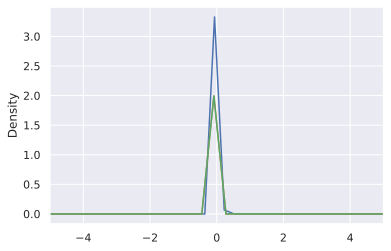

/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.25 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.55 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.25 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


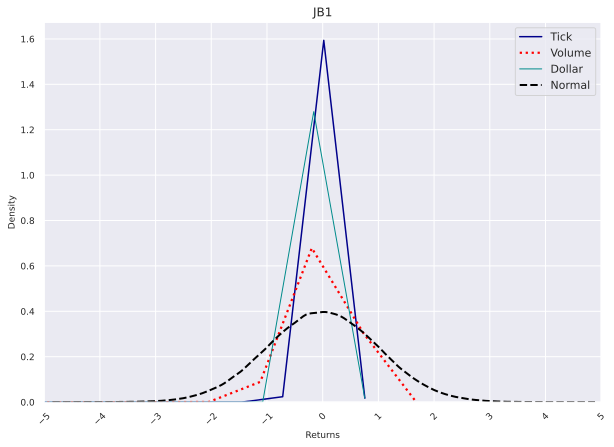

In [80]:
import seaborn as sns

bar_returns = [tr, vr, dr]
bar_types = ['tick','volume','dollar']


fig, ax = plt.subplots(figsize=(10,7))
#sns.kdeplot(time_standard, label="Time", bw=0.30, color='darkred')
sns.kdeplot(tick_standard, 
            ax=ax,
            label="Tick", 
            bw=0.25,
            color='darkblue')
sns.kdeplot(volume_standard,
            ax=ax,
            label="Volume",
            bw=0.55,linewidth=2.25,
            color='red', linestyle =':')
sns.kdeplot(dollar_standard,
            ax=ax,
            label="Dollar",
            bw=0.25,
            linewidth=1,
            color='darkcyan')
sns.kdeplot(np.random.normal(size=len(tick_standard)),
            ax=ax,
            label="Normal",
            color='black',
            linewidth=2,
            linestyle="--")

_=ax.set_xticks(range(-5, 6))
_=ax.set_xlim(-5, 5)
plt.xlabel('Returns', fontsize=9)
plt.ylabel('Density', fontsize=9)
plt.xticks(fontsize = 9, rotation = 45)
plt.yticks(fontsize = 9)
plt.title(str(testSymbol))

file_name = testSymbol+'_'+str(hash_of_file) + '_multiclocks_density_plot.png'
plt.savefig(os.path.join(figures_destination,file_name))
plt.legend()
plt.show()



In [123]:
# Simple normality tests
from scipy.stats import shapiro, normaltest, jarque_bera
bar_choice = volume_standard.values
stat, p = shapiro(bar_choice)
print('stat = %.3f, p = %.3f\n ' % (stat, p))
if p > 0.05:
    print('prob gaussian')
else:
    print('non gaussian')

stat_nt, p_nt = normaltest(bar_choice)

print('stat = %.3f, p = %.3f\n ' % (stat_nt, p_nt))

stat_jb, p_jb = jarque_bera(bar_choice)

print('stat = %.3f, p = %.3f\n ' % (stat_jb, p_jb))

/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


stat = 0.001, p = 0.000
 
non gaussian
stat = 7759561.809, p = 0.000
 
stat = 72780708557874.641, p = 0.000
 


In [96]:
symbol

'KE1'

USDVolume bars clock


/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

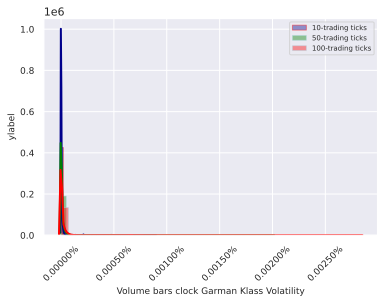

/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

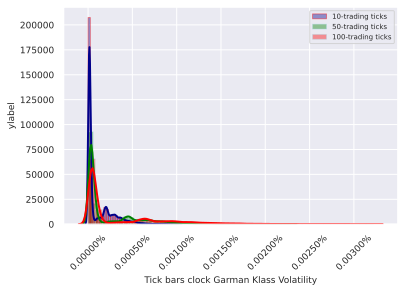

/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

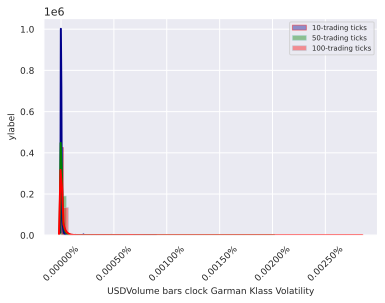

In [82]:
import scipy
barIdx = 2
from matplotlib.ticker import PercentFormatter
print(barsKeys[barIdx])
for barIdx in range(0,3):
    vol_estimation = volatilityEstimation(bars[barsKeys[barIdx]])

    garman_klass_vol_10 = vol_estimation.garmanKlass(trading_periods = 10)
    garman_klass_vol_50 = vol_estimation.garmanKlass(trading_periods = 50)
    garman_klass_vol_100 = vol_estimation.garmanKlass(trading_periods = 100)

    g1 =sns.distplot(garman_klass_vol_10, hist=True, kde=True, 
                 bins=int(200/5), color = 'darkblue', 
                 hist_kws={'edgecolor':'red'},
                 kde_kws={'linewidth': 2}, 
                    label="10-trading ticks")
    g2 =sns.distplot(garman_klass_vol_50, hist=True, kde=True, 
                 bins=int(200/5), color = 'green', 
                 hist_kws={'edgecolor':'lightblue'},
                 kde_kws={'linewidth': 2},
                    label="50-trading ticks")
    g3 =sns.distplot(garman_klass_vol_100, hist=True, kde=True, 
                 bins=int(200/5), color = 'red', 
                 hist_kws={'edgecolor':'lightblue'},
                 kde_kws={'linewidth': 2},
                    label="100-trading ticks")
    plt.xlabel('xlabel', fontsize=9)
    plt.ylabel('ylabel', fontsize=9)
    plt.xticks(fontsize = 9, rotation = 45)
    plt.yticks(fontsize = 9)
    plt.gca().xaxis.set_major_formatter(PercentFormatter(10))
    plt.legend(fontsize=7)
    _=plt.xlabel(str(barsKeys[barIdx])+' Garman Klass Volatility') #y label
#     file_name = str(barsKeys[barIdx])+'_GK-Klass Histogram.png'
#     plt.savefig(os.path.join(figures_destination,file_name))
    plt.show()

USDVolume bars clock


/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


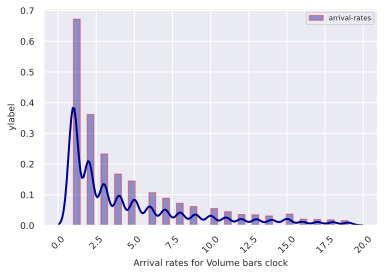

/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


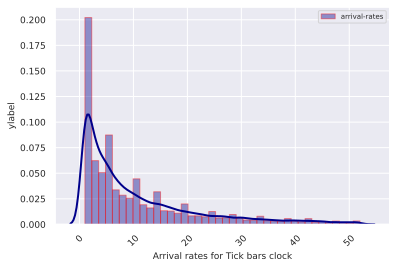

/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


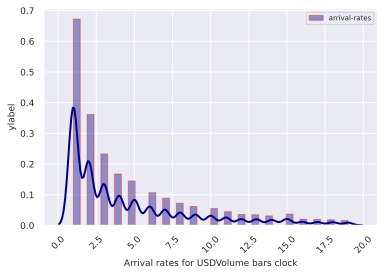

In [85]:
print(barsKeys[barIdx])
for barIdx in range(0,3):
    vol_estimation = volatilityEstimation(bars[barsKeys[barIdx]])
    arrival_rates = vol_estimation.arrival_rates()

    g1 =sns.distplot(arrival_rates, hist=True, kde=True, 
                 bins=int(200/5), color = 'darkblue', 
                 hist_kws={'edgecolor':'red'},
                 kde_kws={'linewidth': 2}, 
                    label="arrival-rates")
    # g2 =sns.distplot(garman_klass_vol_50, hist=True, kde=True, 
    #              bins=int(200/5), color = 'green', 
    #              hist_kws={'edgecolor':'lightblue'},
    #              kde_kws={'linewidth': 2},
    #                 label="50-trading ticks")
    # plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
    plt.xlabel('xlabel', fontsize=9)
    plt.ylabel('ylabel', fontsize=9)
    plt.xticks(fontsize = 9, rotation = 45)
    plt.yticks(fontsize = 9)
    #plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
    plt.legend(fontsize=7)
    _=plt.xlabel('Arrival rates for '+ str(barsKeys[barIdx])) #y label
  
    file_name = testSymbol+'_'+str(hash_of_file) + str(barsKeys[barIdx]) +'arrival-rates.png'
    plt.savefig(os.path.join(figures_destination,file_name))
    plt.show()

In [125]:


# print(barsKeys[barIdx])
# for barIdx in range(0,3):
#     vol_estimation = volatilityEstimation(bars[barsKeys[barIdx]])
#     relative_jump_measure_20 = vol_estimation.relative_jump_measure(200)
#     print(pd.DataFrame(relative_jump_measure_20).quantile([.1, .2, .75]).style.format("{:.2%}"))

# #     g1 =sns.distplot(relative_jump_measure_10, hist=True, kde=True, 
# #                  bins=int(200/5), color = 'darkblue', 
# #                  hist_kws={'edgecolor':'red'},
# #                  kde_kws={'linewidth': 2}, 
# #                     label="10-trading-ticks")
    
#     g2 =sns.distplot(relative_jump_measure_20, hist=True, kde=True, 
#                  bins=int(200/5), color = 'green', 
#                  hist_kws={'edgecolor':'lightblue'},
#                  kde_kws={'linewidth': 2},
#                     label="200-trading ticks")
    
#     # plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
#     plt.legend()
#     _=plt.xlabel('Relative jump metric for '+ str(barsKeys[barIdx])) #y label

#     file_name = testSymbol+'_'+str(hash_of_file) + str(barsKeys[barIdx]) +'relative_jump_metric.png'
    
#     plt.savefig(os.path.join(figures_destination,file_name))
#     plt.show()